# Heart Disease Detection with Machine Learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
import shap

### Data Loading and Sampling

In [2]:
df = pd.read_csv('heart.csv')

In [3]:
df.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [4]:
X = df.drop('target', axis = 1)
y = df['target']

### Data Visualization

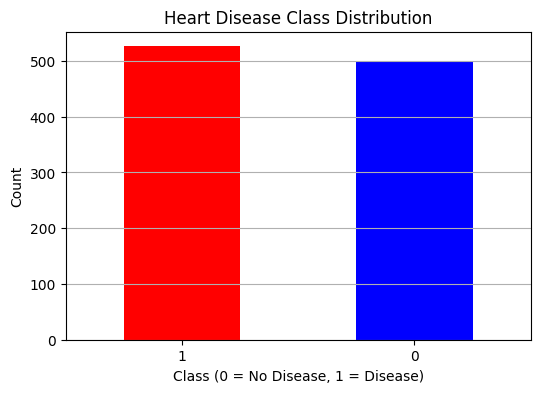

In [7]:
plt.figure(figsize=(6,4))
y.value_counts().plot(kind = 'bar', color = ['red', 'blue'])
plt.title('Heart Disease Class Distribution')
plt.xlabel('Class (0 = No Disease, 1 = Disease)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

<Axes: >

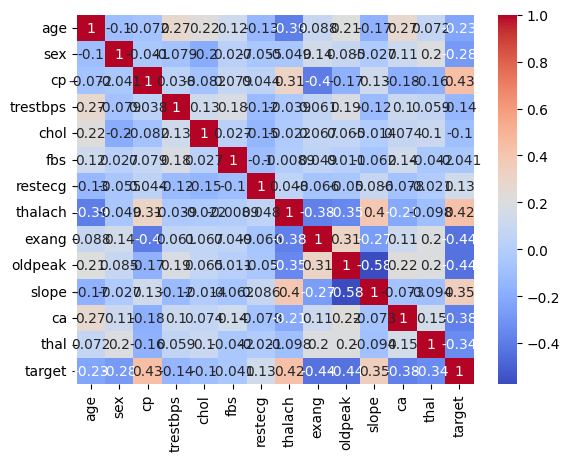

In [8]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

### Model Training with Cross - Validation

0.9159095210868795
0.7537809469356639
0.9968571428571428
0.9998285714285714


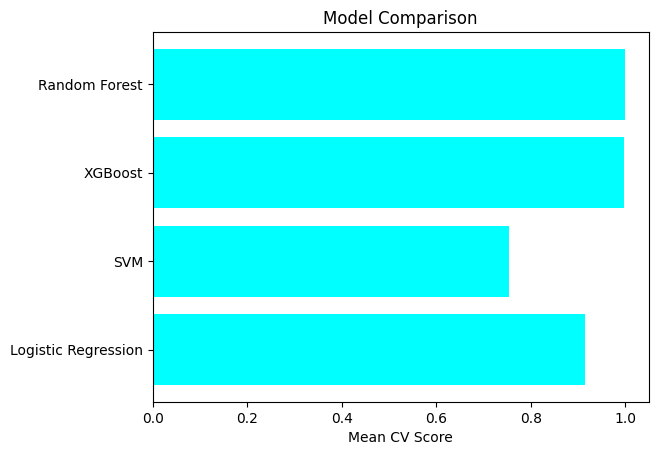

In [9]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1234)
lr = cross_val_score(LogisticRegression(max_iter = 10000), X, y, cv = skf, scoring='roc_auc')
svm = cross_val_score(SVC(), X, y, cv = skf, scoring='roc_auc')
xgb = cross_val_score(XGBClassifier(), X, y, cv = skf, scoring='roc_auc')
rfc = cross_val_score(RandomForestClassifier(), X, y, cv = skf, scoring='roc_auc')
print(lr.mean())
print(svm.mean())
print(xgb.mean())
print(rfc.mean())
model_names = ['Logistic Regression', 'SVM', 'XGBoost', 'Random Forest']
cv_scores = [lr.mean(), svm.mean(), xgb.mean(), rfc.mean()]

plt.barh(model_names, cv_scores, color='cyan')
plt.xlabel('Mean CV Score')
plt.title('Model Comparison')
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

### Hyperparameter Tuning

In [11]:
clf = GridSearchCV(RandomForestClassifier(),{
    'n_estimators' : [100,200],
    'max_depth': [10, 20],
    'min_samples_split': [2,5],
    'min_samples_leaf':[1,2],
}, cv = skf, return_train_score = False)

clf.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

In [12]:
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.9829268292682926


### Training Chosen Model

In [13]:
rfc = RandomForestClassifier(max_depth = 10, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

### Model Evaluation

Roc Auc Score: 1.0
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       101
           1       1.00      0.97      0.99       104

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



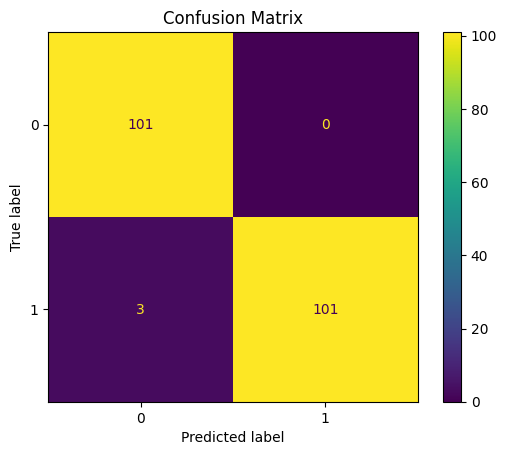

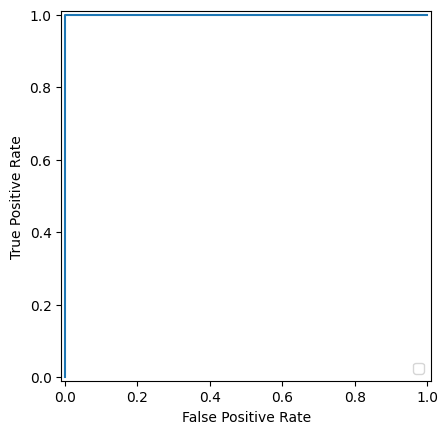

In [14]:
y_proba = rfc.predict_proba(X_test)[:,1]

print("Roc Auc Score:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
